##**What Causes a Pandemic?**

Data 698 Final Project

###Install Libraries

In [1]:
!pip install geopandas

In [2]:
!pip install geehydro

In [3]:
!pip install pyproj

In [4]:
! --NotebookApp.iopub_data_rate_limit=1.0e10

/bin/bash: --NotebookApp.iopub_data_rate_limit=1.0e10: command not found


In [5]:
import ee
import pandas as pd
import folium
import geehydro
import csv
from sklearn.metrics import mean_squared_error
import logging
import time
import collections
import folium
import geopandas as gpd
from shapely.geometry import Polygon
from functools import partial
import pyproj
from shapely.ops import transform
from shapely.geometry import Point
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot
from statistics import mean
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
import statsmodels.stats.multicomp as ml
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import geopy
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent='Geocoder')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=_okAzAe6sJyEhLcghf4wHKN77zH7WGLW8-d2_g7HYS8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6fObcVLTWlyfl8B4wHu7anIc1wVbs9Vrgswy8pPooOidsVnrdz33g

Successfully saved authorization token.


### Define Functions

In [7]:
#https://gis.stackexchange.com/questions/289044/creating-buffer-circle-x-kilometers-from-point-using-python
#Creates a buffer around a lat,long point on a map

def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    proj_wgs84 = pyproj.Proj('+proj=longlat +datum=WGS84')
    aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
    project = partial(
        pyproj.transform,
        pyproj.Proj(aeqd_proj.format(lat=lat, lon=lon)),
        proj_wgs84)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(project, buf).exterior.coords[:]

In [8]:
def simulate_points_in_range(df, i = 1):

  #empty lists
  disease = []
  animal = []
  origin_lat = []
  origin_long = []
  new_lat_ = []
  new_long_ = []
  polygon_ = []

  for index, row in df.iterrows():
    for i in range(5):
      try:
        #randomly simulate choosing points within x degrees of latitude/longitude
        new_lat = (row['latitude']+random.random())*random.choice([(i * -1), i])
        new_long = (row['longitude']+random.random())*random.choice([(i * -1), i])
        #creates a circular polygon surrounding the latitude, longitude
        #there is a 10km geodesic buffer
        b = geodesic_point_buffer(new_lat, new_long, 10.0)

        #append data to lists
        disease.append(row['disease'])
        animal.append(row['animal'])
        origin_lat.append(row['latitude'])
        origin_long.append(row['longitude'])
        new_lat_.append(new_lat)
        new_long_.append(new_long)
        polygon_.append(b)

      except:
        pass

  d = {'disease': disease, 'animal': animal, 'origin_lat':origin_lat, 'origin_long': origin_long, 'new_lat': new_lat_, 'new_long': new_long_, 'polygon': polygon_}
  return pd.DataFrame(data=d)

In [9]:
#reduces polygon data to get the sum or mean statistics from the region
def reduce_range_region(df, image, reducer_type, image_var):

  x = []

  for index, row in df.iterrows():
    try:
      #brings in polygon data
      b = row['polygon']
      polygon = ee.Geometry.Polygon(b)
      #reduces data (https://developers.google.com/earth-engine/guides/reducers_reduce_region)
      if reducer_type == 'sum':
        stats = image.reduceRegion(reducer= ee.Reducer.sum(), geometry=polygon, scale=30, maxPixels = 1000)
      else:
          stats = image.reduceRegion(reducer= ee.Reducer.mean(), geometry=polygon, scale=30, maxPixels = 1000)
      data = stats.getInfo()
      x.append(data.pop(image_var))
    except:
      x.append(0)

  return x

In [10]:
#Filters Dataframe on variable1 into an array on variable2
def make_array(list_, variable1, variable2, df):
  df = df[df[variable1].isin(list_)]
  return df[variable2].to_numpy()

In [11]:
#Creates Random Coordinates for Testing 
def random_coordinates(x):
  lat_ = random.randrange(-90, 90)
  long_ = random.randrange(-180, 180)

  #check if on land
  coordinates = (lat_, long_)
  location = locator.reverse(coordinates)
  location = locator.reverse(coordinates)
  
  if ((abs(float(location[1][0]) - float(coordinates[0])) <= 1)) == True and ((abs(float(location[1][1]) - float(coordinates[1]))) <= 1) == True:
    x.append(coordinates)

In [12]:
#Color Codes Map Data
def colors(df):
    if df['animal'] == 'Primates':
        return 'green'
    elif df['animal'] == 'Tick':
        return 'blue'
    elif df['animal'] == 'Bat':
        return 'red'
    elif df['animal'] == 'Rodent':
        return 'darkpurple'
    elif df['animal'] == 'Humans':
        return 'black'
    elif df['animal'] == 'Unknown':
        return 'orange'
    elif df['animal'] == 'Domestic Animal':
        return 'black'
    elif df['animal'] == 'Fish':
        return 'black'
    elif df['animal'] == 'Birds':
        return 'pink'
    elif df['animal'] == 'Flea':
        return 'darkblue'
    else:
        return 'lightgray'

In [13]:
def set_x_y(df, dependent, independent):
  X=df[independent]
  Y=df[dependent].values

  sc_X=StandardScaler()
  X[independent]=sc_X.fit_transform(X[independent])
  df[independent]=sc_X.fit_transform(df[independent])

  return X, Y

def train_test(X, Y):
  (p, n) = X.shape
  theta = np.zeros((n+1,1)) 
  ones = np.ones((p,1))
  X = np.hstack((ones, X))

  X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,random_state=0)
  m=len(Y_train)

  return X_train, Y_train, Y_test, X_test, theta, m

def sigmoid(x):
  return 1/(1+np.exp(-x))

#compute the cost function
def costFunction(theta, X_train, Y_train, m):
    J = (-1/m) * np.sum(np.multiply(Y_train, np.log(sigmoid(X_train @ theta))) 
        + np.multiply((1-Y_train), np.log(1 - sigmoid(X_train @ theta))))
    return J

#gradient descent 
def gradientdescent(X_train, Y_train, theta, m):
    for _ in range(1500):
        theta = theta - ((0.01/m) * X_train.T @ (sigmoid(X_train @ theta) - Y_train))
    return theta

def predict(X_train, theta):
    return sigmoid(X_train @ theta) >= 0.5

def run_gradient_descent_accuracy(df, dependent, independent):
  X, Y = set_x_y(df, dependent, independent)
  X_train, Y_train, Y_test, X_test, theta, m = train_test(X, Y)
  theta = gradientdescent(X_train, Y_train, theta, m)
  J = costFunction(theta, X_train, Y_train, m)
  accuracy=(predict(X_train, theta) == Y_train).sum() / m
  
  return accuracy, Y_test, X_test, theta, m

In [14]:
#Importance of Random Forest Predictors
def test_model(df, rf):
  result = pd.concat((pd.DataFrame(df.iloc[:, 1:].columns, columns = ['variable']), 
           pd.DataFrame(rf.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)[:20]
  return result

###Bring In Data

*   Google Earth Engine
*   Epidemic Origin Data
*   Simulated Non-Epidemic Origin Coordinate Data




In [15]:
#https://en.wikipedia.org/wiki/List_of_epidemics
#https://eidr.ecohealthalliance.org/events
epidemics = pd.read_csv('epidemics.csv')

In [16]:
#Forest Loss Data
#https://developers.google.com/earth-engine/datasets/catalog/UMD_hansen_global_forest_change_2019_v1_7?hl=en
gfcImage = ee.Image('UMD/hansen/global_forest_change_2015')
lossImage = gfcImage.select(['loss'])
#Climate Data
#https://developers.google.com/earth-engine/datasets/catalog/WORLDCLIM_V1_BIO?hl=en#description
climate_data = ee.Image('WORLDCLIM/V1/BIO')
annualMeanTemperature = climate_data.select(['bio01'])
#Demographic Data
#https://developers.google.com/earth-engine/datasets/catalog/CIESIN_GPWv411_GPW_Basic_Demographic_Characteristics?hl=en#description
pop = ee.ImageCollection("CIESIN/GPWv411/GPW_Basic_Demographic_Characteristics").first();
raster = pop.select('basic_demographic_characteristics');
#Cropcover Data
#https://developers.google.com/earth-engine/datasets/catalog/USGS_GFSAD1000_V1#bands
cropcover = ee.Image('USGS/GFSAD1000_V1').select('landcover')
#Distribution of Surface Water Data
#https://developers.google.com/earth-engine/datasets/catalog/JRC_GSW1_2_Metadata
water = ee.Image('JRC/GSW1_2/Metadata').select(['detections'])


In [17]:
#ran in previous iteration

#sample_coordinates = []

#for i in range(500):
#  random_coordinates(sample_coordinates)

In [18]:
#output from previous iteration saved 
sample_coordinates = [(-11, 37),
 (-44, -66),
 (-5, 36),
 (-7, -41),
 (65, 31),
 (-21, -59),
 (52, 73),
 (48, 34),
 (-15, -63),
 (61, 79),
 (50, 37),
 (50, -116),
 (52, 34),
 (41, 49),
 (29, 81),
 (-24, 28),
 (56, 54),
 (28, 80),
 (-28, 145),
 (24, -13),
 (56, 92),
 (72, 124),
 (-29, 114),
 (10, -7),
 (-28, 121),
 (-10, -60),
 (37, 121),
 (43, 118),
 (-13, -62),
 (10, -76),
 (1, -51),
 (51, 74),
 (-24, 147),
 (-3, 147),
 (22, 82),
 (37, 114),
 (51, 84),
 (51, -125),
 (47, 107),
 (40, -116),
 (34, -97),
 (29, 1),
 (0, 103),
 (23, 84),
 (-32, 128),
 (27, 75),
 (48, 94),
 (58, 83),
 (-17, 24),
 (33, -98),
 (-19, 138),
 (51, -102),
 (35, -1),
 (45, 103),
 (39, 110),
 (54, 51),
 (22, -14),
 (36, -76),
 (30, 54),
 (-7, -37),
 (-11, -56),
 (-25, -59),
 (43, -111),
 (4, -54),
 (4, 10),
 (35, 2),
 (-23, 15),
 (33, 62),
 (-10, -76),
 (-6, -49),
 (-5, -73),
 (68, 19),
 (-7, 31),
 (35, -96),
 (36, 138),
 (43, 27),
 (-33, 121),
 (57, 67),
 (24, 87),
 (54, 43),
 (-24, 24),
 (48, -110),
 (51, -67),
 (37, 83),
 (57, -130),
 (52, 22),
 (33, 72),
 (41, -76),
 (-2, 100),
 (31, 97),
 (1, -1),
 (32, 43),
 (30, 49),
 (43, -84),
 (-4, -66),
 (30, 49),
 (21, 110),
 (41, -98),
 (-37, -70),
 (17, 48),
 (6, 19),
 (43, 111),
 (59, 25),
 (55, 43),
 (-27, 136),
 (-14, 143),
 (42, -73),
 (55, -112),
 (-31, 28),
 (66, 28),
 (4, 44),
 (62, 154),
 (-25, -67),
 (45, 110),
 (-36, 149),
 (28, 116),
 (-5, -62),
 (-17, 47),
 (53, 33),
 (42, 122),
 (25, -103),
 (17, -95),
 (-33, 122),
 (22, 70),
 (55, 55),
 (28, 16),
 (41, 26),
 (-12, 16),
 (14, 47),
 (47, 48),
 (69, 88),
 (49, 42),
 (-18, -53),
 (21, 98),
 (56, 102),
 (24, 86),
 (35, -90),
 (63, 57),
 (44, -76),
 (21, 86),
 (-26, 147),
 (46, -95),
 (2, 32),
 (3, 28),
 (41, -106),
 (10, 32),
 (17, 99),
 (44, 17),
 (34, 64),
 (40, 80),
 (49, -103),
 (48, 13),
 (34, 76),
 (62, -44),
 (19, 36),
 (-1, 112),
 (38, -103),
 (15, -84),
 (68, 65),
 (32, 79),
 (-10, 149),
 (55, 89),
 (36, 118),
 (-7, 140),
 (-23, 130),
 (37, 100),
 (25, 42),
 (48, 122),
 (-24, 29),
 (-1, 175),
 (44, 90),
 (43, 85),
 (16, 6),
 (44, 54),
 (-20, 136),
 (-33, 148),
 (68, 33),
 (56, 115),
 (26, 100),
 (42, 100),
 (-18, -42),
 (5, 33),
 (16, -90),
 (28, -111),
 (57, 76),
 (55, 91),
 (36, -89),
 (70, 20),
 (33, -88),
 (28, 73),
 (7, 18),
 (-24, 133),
 (44, -122),
 (-15, -56),
 (29, 34),
 (-42, -67),
 (-4, 29),
 (41, -82),
 (41, 36),
 (37, 138),
 (61, 124),
 (29, 91),
 (54, -1),
 (64, 141),
 (-25, 120),
 (46, 117),
 (26, 98),
 (-27, 22),
 (26, 88),
 (23, 110),
 (50, 43),
 (64, 31),
 (48, 3),
 (39, 62),
 (-21, 142),
 (50, 66),
 (54, 111),
 (21, 104),
 (53, 40),
 (-28, -56),
 (51, 33),
 (13, 35),
 (22, -10),
 (53, 129),
 (25, 70),
 (-6, -80),
 (-3, 30),
 (-7, 157),
 (-19, -41),
 (2, -51),
 (65, 30),
 (54, 55),
 (55, 76),
 (-15, -64),
 (42, 104),
 (36, 138),
 (71, 24),
 (15, 35),
 (-16, 30),
 (-6, 107),
 (42, 67),
 (24, 53),
 (56, 93),
 (49, 65),
 (-39, -68),
 (-27, 116),
 (-15, -59),
 (34, -104),
 (50, 3),
 (-26, 31),
 (6, 30),
 (36, 41),
 (4, 101),
 (-16, -62),
 (12, 15),
 (51, -97),
 (48, -112),
 (11, 4),
 (9, 9),
 (66, 44),
 (44, -108),
 (26, 75),
 (-7, 23),
 (33, 85),
 (45, 40),
 (-33, 144),
 (52, 39),
 (43, 78),
 (57, 47),
 (-10, -65),
 (-13, 29),
 (49, 130),
 (-10, 150),
 (43, -98),
 (49, 130),
 (55, -129),
 (56, 159),
 (52, -85),
 (10, 39),
 (52, 35),
 (32, 110),
 (31, 30),
 (56, 100),
 (-2, 15),
 (26, 79),
 (7, 46),
 (-41, 148),
 (54, 29),
 (71, 26),
 (52, -66),
 (3, 12),
 (43, 16),
 (25, 115),
 (6, 16),
 (14, 9),
 (-30, 122),
 (55, -62),
 (37, 38),
 (-11, 36),
 (50, 97),
 (52, 9),
 (60, 93),
 (-23, -50),
 (30, 24),
 (-32, 22),
 (1, 14),
 (37, 44),
 (30, 36),
 (-7, 146),
 (-3, -47),
 (-6, -75),
 (13, 27),
 (-3, 19),
 (49, -112),
 (19, 33),
 (47, -94),
 (50, 96),
 (20, -103),
 (4, -60),
 (28, -106),
 (-12, 131),
 (46, 17),
 (13, 17),
 (68, 14),
 (-36, -59),
 (49, 133),
 (27, 67),
 (55, -122),
 (44, 134),
 (57, 104),
 (17, -15),
 (7, 6),
 (-22, 23),
 (33, -90),
 (39, 58),
 (25, -81),
 (-22, 138),
 (43, 107),
 (19, 101),
 (45, 6),
 (61, -45),
 (46, 86),
 (13, 38),
 (29, 59),
 (12, 25),
 (40, -88),
 (6, 15),
 (-13, 15),
 (59, 98),
 (-15, -58),
 (65, -112),
 (28, 93),
 (-14, 49),
 (54, 119),
 (46, 79),
 (51, 92),
 (27, 103),
 (28, 114),
 (62, 16),
 (54, 109),
 (49, 85),
 (28, 89),
 (-34, -58),
 (-33, 147),
 (51, 25),
 (46, -93),
 (14, 121),
 (43, 90),
 (60, 164),
 (-2, 19),
 (39, -103),
 (11, -7),
 (67, 149),
 (31, -83),
 (56, 65),
 (-34, 151),
 (42, 117),
 (-3, 116),
 (47, -63),
 (51, 43),
 (20, 97),
 (2, -73),
 (38, -4),
 (24, 110),
 (26, -101),
 (2, 41),
 (33, 60),
 (-53, -71),
 (-34, 24),
 (8, 10),
 (19, 103),
 (-26, 121),
 (1, 42),
 (-16, -66),
 (6, -67),
 (33, 109),
 (56, 28),
 (17, -9),
 (51, 1),
 (54, 23),
 (64, -19),
 (31, 76),
 (23, -5),
 (54, 101),
 (-35, -60),
 (15, 39),
 (50, 98),
 (-13, 49),
 (48, 32),
 (17, -11),
 (10, -76),
 (32, 99),
 (2, 33),
 (43, -74),
 (39, 106),
 (47, 101),
 (43, 118),
 (62, 70),
 (48, 125),
 (32, 74),
 (29, 71),
 (61, 77),
 (71, 147),
 (17, -12),
 (9, 34),
 (-2, 119),
 (-4, -56),
 (-34, 151),
 (33, 37),
 (-32, 149),
 (34, 5),
 (-17, -151),
 (18, 97),
 (63, 129),
 (34, -78),
 (29, -105),
 (60, 41),
 (-32, 136),
 (45, -100),
 (43, 68),
 (56, 89),
 (55, 23),
 (39, 66),
 (-33, 116),
 (13, 32),
 (34, 63),
 (41, -93),
 (-14, -60),
 (-21, 123),
 (52, 88),
 (38, -91),
 (55, 35),
 (77, 101),
 (45, -119),
 (-4, 25),
 (-10, -70),
 (59, 16),
 (61, 51),
 (35, 44),
 (-19, 22),
 (-13, 35),
 (-8, 159),
 (23, -103),
 (48, 124),
 (-5, 13),
 (44, 87),
 (43, -124),
 (63, 19),
 (-19, 18),
 (10, 48),
 (30, 62),
 (11, -9),
 (-30, 126),
 (44, 88),
 (43, 123),
 (7, 38),
 (28, 31),
 (26, -81),
 (43, 63),
 (55, 39),
 (24, 96),
 (53, 104),
 (44, -119),
 (59, 50),
 (-27, 25),
 (54, 63),
 (22, 99),
 (54, -5),
 (34, 76),
 (65, 29),
 (-31, 134),
 (42, 62),
 (46, -104),
 (49, 88),
 (19, 54),
 (55, 41),
 (55, 73),
 (43, 107),
 (44, -66),
 (-5, 140),
 (68, 164),
 (49, 113),
 (34, 7),
 (66, 51),
 (68, 164),
 (-27, 140),
 (-3, 13),
 (30, 51),
 (16, 48),
 (7, -58),
 (0, 111),
 (50, 54),
 (66, 58),
 (58, -117),
 (-8, -36),
 (42, 14),
 (62, 8),
 (49, 76),
 (23, 32),
 (-14, 40),
 (58, 13),
 (38, -90),
 (-8, -73),
 (66, -125),
 (24, 8),
 (52, 22),
 (-21, -69),
 (33, 106),
 (69, -128),
 (42, 1),
 (-28, -58),
 (47, 86),
 (52, 43),
 (-42, -74),
 (3, 100),
 (-1, -48),
 (27, 57),
 (-13, -70),
 (-43, -73),
 (63, -116),
 (76, 101),
 (-22, -54),
 (20, -1),
 (12, 43),
 (-10, 17),
 (18, -8),
 (54, -8),
 (-10, -42),
 (-9, 19),
 (-14, -66),
 (-28, -68),
 (21, 81),
 (-18, 130),
 (52, 32),
 (40, 101),
 (25, 29),
 (28, 92),
 (44, 18),
 (14, 35),
 (54, 92),
 (11, 27),
 (39, -102),
 (45, -116),
 (56, 22),
 (39, 142),
 (75, -52),
 (49, 82),
 (45, -68),
 (7, 30),
 (57, 50),
 (21, 81),
 (12, -6),
 (43, 72),
 (19, -72),
 (-19, 15),
 (43, -77),
 (10, -68),
 (11, 4),
 (47, -94),
 (43, 85),
 (2, -66),
 (-42, -73),
 (19, 54),
 (68, -50),
 (59, 79),
 (52, 63),
 (18, 33),
 (52, -10),
 (-20, 120),
 (-3, 120),
 (-32, 144),
 (36, -81),
 (48, 106),
 (31, -105),
 (9, 9),
 (22, -100),
 (44, 126),
 (-46, -69),
 (54, 19),
 (37, 47),
 (46, 142),
 (33, 119),
 (20, -100),
 (49, 4),
 (-9, 25),
 (43, 106),
 (1, -79),
 (31, 31),
 (45, -84),
 (44, -104),
 (63, 19),
 (43, 67),
 (-13, 50),
 (23, 5),
 (48, 10),
 (54, 17),
 (5, -73),
 (37, 65),
 (9, 47),
 (49, -97),
 (39, -121),
 (-36, 144),
 (-20, 31),
 (44, 47),
 (-6, -44),
 (47, -105),
 (44, 67),
 (14, -9),
 (-9, -38),
 (44, 58),
 (15, -8),
 (-30, -63),
 (44, -71),
 (2, 30),
 (40, 80),
 (5, 12),
 (45, -90),
 (-27, -57),
 (-3, 113),
 (44, 78),
 (-17, 145),
 (1, -52),
 (-21, 33),
 (8, 20),
 (18, 80),
 (16, 11),
 (23, 90),
 (66, -19),
 (1, 16),
 (32, 3),
 (-12, 38),
 (54, 136),
 (46, 85),
 (-10, -54),
 (20, -77),
 (42, -94),
 (52, -112),
 (60, 90),
 (64, 47),
 (19, -99),
 (70, 137),
 (36, 102),
 (20, 79),
 (61, 71),
 (48, -59),
 (-7, 17),
 (57, 55),
 (47, 76),
 (39, 96),
 (48, -77),
 (-23, -53),
 (43, 125),
 (26, 56),
 (-14, 142),
 (-15, -53),
 (30, 120),
 (56, -119),
 (10, 13),
 (16, 1),
 (33, 12),
 (-14, 34),
 (-16, 25),
 (20, -97),
 (32, 49),
 (-15, 23),
 (28, 30),
 (27, 99),
 (36, 37),
 (7, 120),
 (68, 133),
 (-35, -60),
 (37, 56),
 (-39, -63),
 (43, 78),
 (48, 7),
 (12, -84),
 (-23, 29),
 (57, 30),
 (52, -124),
 (9, 42),
 (27, 57),
 (-22, 18),
 (34, 80),
 (44, 110),
 (15, 78),
 (63, 45),
 (-30, -51),
 (-23, -64),
 (59, 95),
 (30, 108),
 (57, 70),
 (-27, 30),
 (36, 105),
 (64, -137),
 (49, -112),
 (-20, 144),
 (13, 10),
 (58, 84),
 (15, 21),
 (-3, -71),
 (-45, -59),
 (50, 6),
 (34, -81),
 (48, 53),
 (-4, -55),
 (-5, 142),
 (43, 73),
 (-15, -73),
 (-31, 137),
 (1, -76),
 (51, 30),
 (67, -51),
 (60, 163),
 (28, -11),
 (-4, 140),
 (-27, -58),
 (60, 49),
 (57, -3),
 (-22, -45),
 (11, 13),
 (-12, -44),
 (43, 112),
 (-15, 12),
 (-30, -62),
 (10, 47),
 (68, 129),
 (31, 109),
 (28, 56),
 (0, 9),
 (44, -116),
 (47, -106),
 (-31, 121),
 (-11, -41),
 (33, 81),
 (-22, 32),
 (69, -129),
 (29, -6),
 (63, 49),
 (60, 134),
 (41, 47),
 (66, 51),
 (13, 24),
 (21, -99),
 (44, -99),
 (48, -80),
 (40, 140),
 (37, 55),
 (63, 27),
 (-45, -66),
 (30, -109),
 (24, -110),
 (42, 118),
 (58, 11),
 (-30, 121),
 (52, -69),
 (21, 17),
 (14, 7),
 (56, -113),
 (-7, -50),
 (13, 105),
 (64, 9),
 (45, -69),
 (59, 9),
 (-42, -72),
 (-25, 152),
 (40, 111),
 (-13, 18),
 (-28, 141),
 (-15, 24),
 (44, 26),
 (59, 55),
 (-32, -70),
 (59, 17),
 (62, -70),
 (66, -40),
 (5, 14),
 (50, 15)]

In [19]:
#union epidemic & non epidemic data

lat_list = []
lon_list = []
animal = []
disease = []
coded_animal = []
for a, o in sample_coordinates:
  lat_list.append(a)  
  lon_list.append(o)
  animal.append('None')
  disease.append('None')
  coded_animal.append(0)
non_epidemic_sites = pd.DataFrame(list(zip(lat_list, lon_list, animal, disease, coded_animal)),
                                  columns =['latitude', 'longitude', 'animal', 'disease', 'coded_animal']) 
non_epidemic_sites['epidemic_presence'] = 0
epidemics['epidemic_presence'] = 1
epidemic_full = pd.concat([epidemics, non_epidemic_sites])

###Get Reduced Google Earth Data for Long/Lat Points

In [20]:
#Data Run on Previous Iteration and Saved
'''#Forest Loss
#Get polygons for 1 degree
epidemics_1 = simulate_points_in_range(epidemic_full)
#Get polygons for 3 degrees
epidemics_3 = simulate_points_in_range(epidemic_full, i = 3)
epidemics_1['forest_loss_1'] = reduce_range_region(epidemics_1, lossImage, 'sum', 'loss')
epidemics_3['forest_loss_3'] = reduce_range_region(epidemics_3, lossImage, 'sum', 'loss')
#Climate
epidemics_1['climate_data_1'] = reduce_range_region(epidemics_1, annualMeanTemperature, 'mean', 'bio01')
epidemics_3['climate_data_3'] = reduce_range_region(epidemics_3, annualMeanTemperature, 'mean', 'bio01')
#Demographic
epidemics_1['demographic_1'] = reduce_range_region(epidemics_1, raster, 'mean', 'basic_demographic_characteristics')
epidemics_3['demographic_3'] = reduce_range_region(epidemics_3, raster, 'mean', 'basic_demographic_characteristics')
#Cropcover
epidemics_1['cropcover_1'] = reduce_range_region(epidemics_1, cropcover, 'mean', 'landcover')
epidemics_3['cropcover_3'] = reduce_range_region(epidemics_3, cropcover, 'mean', 'landcover')
#Water
epidemics_1['water_1'] = reduce_range_region(epidemics_1, water, 'mean', 'detections')
epidemics_3['water_3'] = reduce_range_region(epidemics_3, water, 'mean', 'detections')
#Clean Data
epidemics_1 = epidemics_1.fillna(0)
epidemics_3 = epidemics_3.fillna(0)
epidemics_1["epidemic_presence"] = epidemics_1["disease"].map(lambda x: 0 if "None" in x else 1)
epidemics_3["epidemic_presence"] = epidemics_3["disease"].map(lambda x: 0 if "None" in x else 1)
#export data
epidemics_1.to_csv('epidemics_1.csv')
epidemics_3.to_csv('epidemics_3.csv')'''

'#Forest Loss\n#Get polygons for 1 degree\nepidemics_1 = simulate_points_in_range(epidemic_full)\n#Get polygons for 3 degrees\nepidemics_3 = simulate_points_in_range(epidemic_full, i = 3)\nepidemics_1[\'forest_loss_1\'] = reduce_range_region(epidemics_1, lossImage, \'sum\', \'loss\')\nepidemics_3[\'forest_loss_3\'] = reduce_range_region(epidemics_3, lossImage, \'sum\', \'loss\')\n#Climate\nepidemics_1[\'climate_data_1\'] = reduce_range_region(epidemics_1, annualMeanTemperature, \'mean\', \'bio01\')\nepidemics_3[\'climate_data_3\'] = reduce_range_region(epidemics_3, annualMeanTemperature, \'mean\', \'bio01\')\n#Demographic\nepidemics_1[\'demographic_1\'] = reduce_range_region(epidemics_1, raster, \'mean\', \'basic_demographic_characteristics\')\nepidemics_3[\'demographic_3\'] = reduce_range_region(epidemics_3, raster, \'mean\', \'basic_demographic_characteristics\')\n#Cropcover\nepidemics_1[\'cropcover_1\'] = reduce_range_region(epidemics_1, cropcover, \'mean\', \'landcover\')\nepidemic

In [21]:
epidemics_1 = pd.read_csv('epidemics_1.csv')
epidemics_3 = pd.read_csv('epidemics_3.csv')

epidemics_1 = epidemics_1[epidemics_1['new_lat']!=0]
epidemics_1 = epidemics_1[epidemics_1['new_long']!=0]
epidemics_3 = epidemics_3[epidemics_3['new_lat']!=0]
epidemics_3 = epidemics_3[epidemics_3['new_long']!=0]

In [22]:
epidemic_data = epidemics_1[epidemics_1['animal']!='None']
in_polygon = []

for index, row in epidemics_1.iterrows():
  point = Point(row['new_lat'], row['new_long'])
  for i in epidemic_data['polygon']:
    polygon = Polygon(eval(i))
    if polygon.contains(point) == True:
      print(point)

POINT (-55.68772524828911 -61.46429129642941)
POINT (57.32850786337787 -61.56052529043809)
POINT (29.49859824589248 -61.58814666289772)


In [23]:
epidemic_data = epidemics_3[epidemics_3['animal']!='None']
in_polygon = []

for index, row in epidemics_3.iterrows():
  point = Point(row['new_lat'], row['new_long'])
  for i in epidemic_data['polygon']:
    polygon = Polygon(eval(i))
    if polygon.contains(point) == True:
      print(point)

POINT (27.15129630127413 27.09327552503909)


In [24]:
epidemics_1 = epidemics_1[(epidemics_1['new_lat']!=-55.68772524828911) & (epidemics_1['new_long']!=-61.46429129642941)]
epidemics_1 = epidemics_1[(epidemics_1['new_lat']!=57.32850786337787) & (epidemics_1['new_lat']!=-61.56052529043809)]
epidemics_1 = epidemics_1[(epidemics_1['new_lat']!=29.49859824589248) & (epidemics_1['new_lat']!=-61.58814666289772)]
epidemics_3 = epidemics_3[(epidemics_3['new_lat']!=27.15129630127413) & (epidemics_3['new_lat']!=27.09327552503909)]

###Map Data

In [25]:
#Datapoints for Analysis
epidemic_full = epidemic_full.reset_index()
locations_full = epidemic_full[['latitude', 'longitude']]
locationlist_full = locations_full.values.tolist()
epidemic_full["color"] = epidemic_full.apply(colors, axis=1)

Locations = folium.Map(location=[0,0], tiles='Stamen Terrain', zoom_start=2)

for point in range(0, len(locationlist_full)):
  folium.Marker(locationlist_full[point], icon=folium.Icon(color=epidemic_full["color"][point])).add_to(Locations)

Locations

In [26]:
#Map Forest Loss Data With Temperature andEpidemic Data

locations = epidemics[['latitude', 'longitude']]
locationlist = locations.values.tolist()
epidemics["color"] = epidemics.apply(colors, axis=1)

temperature_params = {
  'min': -230,
  'max': 300,
  'palette': ['blue', 'purple', 'cyan', 'green', 'yellow', 'red']}

Map = folium.Map(location=[0,0], tiles='Stamen Terrain', zoom_start=2)

Map.addLayer(annualMeanTemperature.updateMask(annualMeanTemperature), temperature_params)

Map.addLayer(lossImage.updateMask(lossImage), {'palette': ['black']}, 'Loss')

for point in range(0, len(locationlist)):
  folium.Marker(locationlist[point], popup=epidemics['disease'][point], icon=folium.Icon(color=epidemics["color"][point])).add_to(Map)

Map

In [27]:
#Population Data and Epidemic Data

raster_vis = {
  "max": 1000.0,
  "palette": [
    "ffffe7",
    "86a192",
    "509791",
    "307296",
    "2c4484",
    "000066"
  ],
  "min": 0.0
};

pop_map = folium.Map(location=[45, 68], tiles='Stamen Terrain', zoom_start=3)

pop_map.addLayer(raster, raster_vis, 'basic_demographic_characteristics');

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=epidemics['disease'][point], icon=folium.Icon(color=epidemics["color"][point])).add_to(pop_map)

pop_map

In [28]:
#Crop Data and Epidemic Data

cropMaskVis = {
  'min': 0.0,
  'max': 5.0,
  'palette': ['black', 'orange', 'brown', '02a50f', 'green', 'yellow'],
};

crop_map = folium.Map(location=[0,0], tiles='Stamen Terrain', zoom_start=2)

crop_map.addLayer(cropcover, cropMaskVis, 'cropcover');

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=epidemics['disease'][point], icon=folium.Icon(color=epidemics["color"][point])).add_to(crop_map)

crop_map

In [29]:
#Surface Water Data and Epidemic Data

visualization = {
  'bands': ['detections'],
  'min': 100.0,
  'max': 900.0,
};

water_map = folium.Map(location=[0,0], tiles='Stamen Terrain', zoom_start=2)

water_map.addLayer(water, visualization, 'water');

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=epidemics['disease'][point], icon=folium.Icon(color=epidemics["color"][point])).add_to(water_map)

water_map

###Dataset Summary

In [30]:
epidemics_1.describe()

,Unnamed: 0,origin_lat,origin_long,new_lat,new_long,forest_loss_1,climate_data_1,demographic_1,cropcover_1,water_1,epidemic_presence
count,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000,2078.000000
mean,1458.739654,13.025236,24.338980,0.209347,-4.556595,3214.523777,32.720415,1.132782,0.209503,14.732351,0.060635
std,845.213452,26.403979,74.468167,47.948814,170.967891,19274.559542,88.575714,6.661617,0.678047,63.763486,0.238717
min,1.000000,-53.000000,-151.000000,-89.966296,-700.098469,0.000000,-248.851848,0.000000,0.000000,-45.797276,0.000000
25%,726.250000,-8.750000,-48.000000,-41.745576,-106.446608,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1459.000000,13.000000,29.190000,1.458213,0.787533,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2192.500000,33.140000,85.000000,40.450715,100.131935,0.000000,0.000000,0.000383,0.000000,0.464000,0.000000
max,2922.000000,77.000000,175.000000,89.817761,630.692316,481588.529412,300.902798,116.905083,4.500927,875.481737,1.000000


In [31]:
epidemics_1.groupby("animal").mean()

,Unnamed: 0,origin_lat,origin_long,new_lat,new_long,forest_loss_1,climate_data_1,demographic_1,cropcover_1,water_1,epidemic_presence
animal,,,,,,,,,,,
Bat,71.107143,8.091071,36.935714,-4.675046,-34.004756,849.298319,58.758390,2.198645,0.243922,13.039473,1.0
Birds,47.166667,30.801667,86.750000,-30.127530,6.004036,314.626144,47.681761,3.578425,0.370676,12.295890,1.0
Domestic Animal,123.222222,16.934444,-43.776667,-7.908484,69.319990,1413.311111,62.278226,6.615272,0.636748,0.803058,1.0
Fish,136.500000,-20.920000,142.700000,19.510089,143.758166,1588.043137,28.824955,6.764592,0.512155,64.525994,1.0
Flea,40.500000,-18.980000,47.020000,19.005185,-94.857990,24.750000,48.597287,0.592104,0.263733,0.339978,1.0
Humans,68.333333,18.921333,47.926667,-21.946536,-5.584559,0.000000,6.424517,0.000000,0.000000,35.269158,1.0
None,1547.404201,12.985143,24.350922,0.456278,-4.431293,3309.747794,31.463554,0.951703,0.205243,13.816029,0.0
Primates,75.461538,17.182308,49.991538,22.021492,-32.865938,1141.348718,82.278771,8.093134,0.128282,27.258399,1.0
Rodent,79.230769,-0.074615,-3.470000,-2.116068,31.516088,926.058220,116.882059,0.654210,0.337305,2.989018,1.0


In [32]:
epidemics_3.groupby("animal").mean()

,Unnamed: 0,origin_lat,origin_long,new_lat,new_long,forest_loss_3,climate_data_3,demographic_3,cropcover_3,water_3,epidemic_presence
animal,,,,,,,,,,,
Bat,71.107143,8.091071,36.935714,-1.087080,-11.782167,1185.794258,66.509297,2.489492,0.279588,12.912150,1.0
Birds,47.166667,30.801667,86.750000,24.326930,86.958844,7580.042484,14.280890,2.972751,0.304044,122.927391,1.0
Domestic Animal,123.222222,16.934444,-43.776667,30.047705,28.251271,8288.366885,51.216808,0.203196,0.310119,2.147797,1.0
Fish,136.500000,-20.920000,142.700000,-0.179922,358.360906,3499.595098,25.415417,0.151255,0.009947,1.263574,1.0
Flea,40.500000,-18.980000,47.020000,9.336376,-48.194581,0.000000,72.904626,0.319653,0.000000,0.034028,1.0
Humans,68.333333,18.921333,47.926667,4.772639,95.939068,2264.258301,23.558075,0.631459,0.274939,52.699036,1.0
None,1548.717791,12.993865,24.308282,-2.753118,1.951369,3331.205423,31.365140,0.981307,0.219645,12.590597,0.0
Primates,75.461538,17.182308,49.991538,-2.426124,-27.041269,372.012670,55.158509,0.828205,0.460079,11.371892,1.0
Rodent,84.416667,-0.633333,-4.253333,-6.260974,16.615335,508.468627,67.147052,1.146296,0.278453,3.377003,1.0


###Run Statistical Significance Tests of Variables

**ANOVA and Tukey Test**

In [33]:
# ANOVA Test Using Animal Origin Types of Forest Loss

loss_mosquito_1 = make_array( ['Primates'], 'animal','forest_loss_1', epidemics_1)
loss_bat_1 =  make_array(['Bat'], 'animal','forest_loss_1', epidemics_1)
loss_tick_1 =  make_array(['Tick'], 'animal','forest_loss_1', epidemics_1)
loss_rodent_1 =  make_array(['Rodent'], 'animal','forest_loss_1', epidemics_1)
loss_unknown_1 =  make_array(['Unknown'], 'animal','forest_loss_1', epidemics_1)
loss_human_1 =  make_array(['Humans','Domestic Animal'], 'animal','forest_loss_1', epidemics_1)
loss_birds_1 =  make_array(['Birds'], 'animal','forest_loss_1', epidemics_1)
loss_none_1 = make_array( ['None'], 'animal','forest_loss_1', epidemics_1)

f_oneway(loss_mosquito_1, loss_bat_1, loss_tick_1, loss_rodent_1, loss_unknown_1, loss_human_1, loss_birds_1, loss_none_1)

F_onewayResult(statistic=0.28252348319701587, pvalue=0.9609874024056633)

In [34]:
loss_mosquito_3 = make_array( ['Primates'], 'animal','forest_loss_3', epidemics_3)
loss_bat_3 =  make_array(['Bat'], 'animal','forest_loss_3', epidemics_3)
loss_tick_3 =  make_array(['Tick'], 'animal','forest_loss_3', epidemics_3)
loss_rodent_3 =  make_array(['Rodent'], 'animal','forest_loss_3', epidemics_3)
loss_unknown_3 =  make_array(['Unknown'], 'animal','forest_loss_3', epidemics_3)
loss_human_3 =  make_array(['Humans','Domestic Animal'], 'animal','forest_loss_3', epidemics_3)
loss_birds_3 =  make_array(['Birds'], 'animal','forest_loss_3', epidemics_3)
loss_none_3 = make_array( ['None'], 'animal','forest_loss_3', epidemics_3)

f_oneway(loss_mosquito_3, loss_bat_3, loss_tick_3, loss_rodent_3, loss_unknown_3, loss_human_3, loss_birds_3, loss_none_3)

F_onewayResult(statistic=1.0638611452290925, pvalue=0.38429150608569773)

In [35]:
mcobj = ml.MultiComparison(epidemics_1.forest_loss_1, epidemics_1.animal)
print(mcobj.tukeyhsd(0.05))

             Multiple Comparison of Means - Tukey HSD, FWER=0.05              
     group1          group2      meandiff  p-adj    lower      upper    reject
------------------------------------------------------------------------------
            Bat           Birds  -534.6722   0.9 -28528.6076 27459.2632  False
            Bat Domestic Animal   564.0128   0.9 -23280.0211 24408.0467  False
            Bat            Fish   738.7448   0.9 -32523.0068 34000.4964  False
            Bat            Flea  -824.5483   0.9 -34086.2999 32437.2033  False
            Bat          Humans  -849.2983   0.9 -20760.0988 19061.5022  False
            Bat            None  2460.4495   0.9  -9383.3981 14304.2971  False
            Bat        Primates   292.0504   0.9 -20592.2713 21176.3721  False
            Bat          Rodent    76.7599   0.9 -20807.5618 20961.0816  False
            Bat            Tick  -293.5497   0.9 -24137.5836 23550.4841  False
            Bat         Unknown  4848.1258   0.9 -12

In [36]:
mcobj = ml.MultiComparison(epidemics_3.forest_loss_3, epidemics_3.animal)
print(mcobj.tukeyhsd(0.05))

              Multiple Comparison of Means - Tukey HSD, FWER=0.05               
     group1          group2       meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------------------------
            Bat           Birds   6394.2482    0.9  -19225.954 32014.4504  False
            Bat Domestic Animal   7102.5726    0.9 -14719.6171 28924.7624  False
            Bat            Fish   2313.8008    0.9 -28127.5355 32755.1372  False
            Bat            Flea  -1185.7943    0.9 -31627.1306 29255.5421  False
            Bat          Humans    1078.464    0.9 -17144.0091 19300.9372  False
            Bat            None   2145.4112    0.9   -8693.986 12984.8083  False
            Bat        Primates   -813.7816    0.9 -19927.2266 18299.6635  False
            Bat          Rodent   -677.3256    0.9 -20327.1237 18972.4725  False
            Bat            Tick  16488.1927 0.3455  -5333.9971 38310.3824  False
            Bat         Unkn

In [37]:
temp_mosquito_1 = make_array( ['Primates'], 'animal', 'climate_data_1', epidemics_1)
temp_bat_1 =  make_array(['Bat'], 'animal', 'climate_data_1', epidemics_1)
temp_tick_1 =  make_array(['Tick'], 'animal', 'climate_data_1', epidemics_1)
temp_rodent_1 =  make_array(['Rodent'], 'animal', 'climate_data_1', epidemics_1)
temp_human_1 =  make_array(['Humans','Domestic Animal'], 'animal', 'climate_data_1', epidemics_1)
temp_unknown_1 =  make_array(['Unknown'], 'animal', 'climate_data_1', epidemics_1)
temp_birds_1 =  make_array(['Birds'], 'animal', 'climate_data_1', epidemics_1)
temp_none_1 =  make_array(['None'], 'animal', 'climate_data_1', epidemics_1)

f_oneway(temp_mosquito_1, temp_bat_1, temp_tick_1, temp_unknown_1, temp_rodent_1, temp_human_1, temp_birds_1, temp_none_1)

F_onewayResult(statistic=3.0010398359941908, pvalue=0.0038807729162756263)

In [38]:
temp_mosquito_3 = make_array( ['Primates'], 'animal', 'climate_data_3', epidemics_3)
temp_bat_3 =  make_array(['Bat'], 'animal', 'climate_data_3', epidemics_3)
temp_tick_3 =  make_array(['Tick'], 'animal', 'climate_data_3', epidemics_3)
temp_rodent_3 =  make_array(['Rodent'], 'animal', 'climate_data_3', epidemics_3)
temp_human_unknown_3 =  make_array(['Humans','Domestic Animal'], 'animal', 'climate_data_3', epidemics_3)
temp_birds_3 =  make_array(['Birds'], 'animal', 'climate_data_3', epidemics_3)
temp_none_3 =  make_array(['None'], 'animal', 'climate_data_3', epidemics_3)

f_oneway(temp_mosquito_3, temp_bat_3, temp_tick_3, temp_rodent_3, temp_human_unknown_3, temp_birds_3, temp_none_3)

F_onewayResult(statistic=1.2701341861402038, pvalue=0.26776294277172635)

In [39]:
mcobj = ml.MultiComparison(epidemics_1.climate_data_1, epidemics_1.animal)
print(mcobj.tukeyhsd(0.05))

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
     group1          group2      meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------
            Bat           Birds  -11.0766    0.9 -139.0659 116.9126  False
            Bat Domestic Animal    3.5198    0.9 -105.4959 112.5356  False
            Bat            Fish  -29.9334    0.9 -182.0073 122.1404  False
            Bat            Flea  -10.1611    0.9  -162.235 141.9128  False
            Bat          Humans  -52.3339   0.72 -143.3667   38.699  False
            Bat            None  -27.2948 0.8618  -81.4453  26.8556  False
            Bat        Primates   23.5204    0.9  -71.9635 119.0042  False
            Bat          Rodent   58.1237 0.6523  -37.3602 153.6075  False
            Bat            Tick  -62.6765   0.72 -171.6923  46.3392  False
            Bat         Unknown  -13.7803    0.9  -92.0652  64.5045  False
          Birds Domestic 

In [40]:
mcobj = ml.MultiComparison(epidemics_3.climate_data_3, epidemics_3.animal)
print(mcobj.tukeyhsd(0.05))

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1          group2     meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------------
            Bat           Birds -52.2284    0.9 -179.9378   75.481  False
            Bat Domestic Animal -15.2925    0.9 -124.0699  93.4849  False
            Bat            Fish -41.0939    0.9 -192.8353 110.6475  False
            Bat            Flea   6.3953    0.9  -145.346 158.1367  False
            Bat          Humans -42.9512    0.9  -133.785  47.8826  False
            Bat            None -35.1442 0.5689  -89.1755  18.8871  False
            Bat        Primates -11.3508    0.9 -106.6259  83.9243  False
            Bat          Rodent   0.6378    0.9  -97.3109  98.5864  False
            Bat            Tick -48.3664    0.9 -157.1438   60.411  False
            Bat         Unknown -62.7461 0.2553 -140.8597  15.3676  False
          Birds Domestic Animal  36.93

In [41]:
temp_mosquito_1 = make_array( ['Primates'], 'animal', 'demographic_1', epidemics_1)
temp_bat_1 =  make_array(['Bat'], 'animal', 'demographic_1', epidemics_1)
temp_tick_1 =  make_array(['Tick'], 'animal', 'demographic_1', epidemics_1)
temp_rodent_1 =  make_array(['Rodent'], 'animal', 'demographic_1', epidemics_1)
temp_human_1 =  make_array(['Humans','Domestic Animal'], 'animal', 'demographic_1', epidemics_1)
temp_unknown_1 =  make_array(['Unknown'], 'animal', 'demographic_1', epidemics_1)
temp_birds_1 =  make_array(['Birds'], 'animal', 'demographic_1', epidemics_1)
temp_none_1 =  make_array(['None'], 'animal', 'demographic_1', epidemics_1)

f_oneway(temp_mosquito_1, temp_bat_1, temp_tick_1, temp_unknown_1, temp_rodent_1, temp_human_1, temp_birds_1, temp_none_1)

F_onewayResult(statistic=6.878749412490361, pvalue=4.158134420036647e-08)

In [42]:
temp_mosquito_1 = make_array( ['Primates'], 'animal', 'demographic_3', epidemics_3)
temp_bat_1 =  make_array(['Bat'], 'animal', 'demographic_3', epidemics_3)
temp_tick_1 =  make_array(['Tick'], 'animal', 'demographic_3', epidemics_3)
temp_rodent_1 =  make_array(['Rodent'], 'animal', 'demographic_3', epidemics_3)
temp_human_1 =  make_array(['Humans','Domestic Animal'], 'animal', 'demographic_3', epidemics_3)
temp_unknown_1 =  make_array(['Unknown'], 'animal', 'demographic_3', epidemics_3)
temp_birds_1 =  make_array(['Birds'], 'animal', 'demographic_3', epidemics_3)
temp_none_1 =  make_array(['None'], 'animal', 'demographic_3', epidemics_3)

f_oneway(temp_mosquito_1, temp_bat_1, temp_tick_1, temp_unknown_1, temp_rodent_1, temp_human_1, temp_birds_1, temp_none_1)

F_onewayResult(statistic=0.451642362380766, pvalue=0.8695346028152052)

In [43]:
mcobj = ml.MultiComparison(epidemics_1.demographic_1, epidemics_1.animal)
print(mcobj.tukeyhsd(0.05))

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------------
            Bat           Birds   1.3798    0.9  -8.1703 10.9298  False
            Bat Domestic Animal   4.4166 0.7839  -3.7177  12.551  False
            Bat            Fish   4.5659    0.9  -6.7812 15.9131  False
            Bat            Flea  -1.6065    0.9 -12.9537  9.7406  False
            Bat          Humans  -2.1986    0.9  -8.9912  4.5939  False
            Bat            None  -1.2469    0.9  -5.2874  2.7936  False
            Bat        Primates   5.8945 0.2163  -1.2301 13.0191  False
            Bat          Rodent  -1.5444    0.9  -8.6691  5.5802  False
            Bat            Tick  -1.7954    0.9  -9.9297  6.3389  False
            Bat         Unknown   6.0756 0.0334   0.2343 11.9169   True
          Birds Domestic Animal   3.0368    0.9  -8.1516 14.2253

In [44]:
mcobj = ml.MultiComparison(epidemics_3.demographic_3, epidemics_3.animal)
print(mcobj.tukeyhsd(0.05))

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
     group1          group2     meandiff p-adj  lower    upper  reject
----------------------------------------------------------------------
            Bat           Birds   0.4833   0.9  -9.1607 10.1272  False
            Bat Domestic Animal  -2.2863   0.9 -10.5006   5.928  False
            Bat            Fish  -2.3382   0.9 -13.7969  9.1204  False
            Bat            Flea  -2.1698   0.9 -13.6285  9.2888  False
            Bat          Humans   -1.858   0.9  -8.7173  5.0012  False
            Bat            None  -1.5082   0.9  -5.5883   2.572  False
            Bat        Primates  -1.6613   0.9  -8.8559  5.5334  False
            Bat          Rodent  -1.3432   0.9  -8.7397  6.0533  False
            Bat            Tick   0.1184   0.9  -8.0958  8.3327  False
            Bat         Unknown  -2.4589   0.9  -8.3576  3.4398  False
          Birds Domestic Animal  -2.7696   0.9  -14.068  8.5288  False
      

In [45]:
temp_mosquito_1 = make_array( ['Primates'], 'animal', 'cropcover_1', epidemics_1)
temp_bat_1 =  make_array(['Bat'], 'animal', 'cropcover_1', epidemics_1)
temp_tick_1 =  make_array(['Tick'], 'animal', 'cropcover_1', epidemics_1)
temp_rodent_1 =  make_array(['Rodent'], 'animal', 'cropcover_1', epidemics_1)
temp_human_1 =  make_array(['Humans','Domestic Animal'], 'animal', 'cropcover_1', epidemics_1)
temp_unknown_1 =  make_array(['Unknown'], 'animal', 'cropcover_1', epidemics_1)
temp_birds_1 =  make_array(['Birds'], 'animal', 'cropcover_1', epidemics_1)
temp_none_1 =  make_array(['None'], 'animal', 'cropcover_1', epidemics_1)

f_oneway(temp_mosquito_1, temp_bat_1, temp_tick_1, temp_unknown_1, temp_rodent_1, temp_human_1, temp_birds_1, temp_none_1)

F_onewayResult(statistic=0.32755583722377873, pvalue=0.9417681320963307)

In [46]:
temp_mosquito_1 = make_array( ['Primates'], 'animal', 'cropcover_3', epidemics_3)
temp_bat_1 =  make_array(['Bat'], 'animal', 'cropcover_3', epidemics_3)
temp_tick_1 =  make_array(['Tick'], 'animal', 'cropcover_3', epidemics_3)
temp_rodent_1 =  make_array(['Rodent'], 'animal', 'cropcover_3', epidemics_3)
temp_human_1 =  make_array(['Humans','Domestic Animal'], 'animal', 'cropcover_3', epidemics_3)
temp_unknown_1 =  make_array(['Unknown'], 'animal', 'cropcover_3', epidemics_3)
temp_birds_1 =  make_array(['Birds'], 'animal', 'cropcover_3', epidemics_3)
temp_none_1 =  make_array(['None'], 'animal', 'cropcover_3', epidemics_3)

f_oneway(temp_mosquito_1, temp_bat_1, temp_tick_1, temp_unknown_1, temp_rodent_1, temp_human_1, temp_birds_1, temp_none_1)

F_onewayResult(statistic=1.2061752867385267, pvalue=0.2957041204760493)

In [47]:
mcobj = ml.MultiComparison(epidemics_1.cropcover_1, epidemics_1.animal)
print(mcobj.tukeyhsd(0.05))

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
            Bat           Birds   0.1268    0.9 -0.8566 1.1101  False
            Bat Domestic Animal   0.3928    0.9 -0.4448 1.2304  False
            Bat            Fish   0.2682    0.9 -0.9002 1.4367  False
            Bat            Flea   0.0198    0.9 -1.1486 1.1882  False
            Bat          Humans  -0.2439    0.9 -0.9434 0.4555  False
            Bat            None  -0.0387    0.9 -0.4547 0.3774  False
            Bat        Primates  -0.1156    0.9 -0.8493  0.618  False
            Bat          Rodent   0.0934    0.9 -0.6402  0.827  False
            Bat            Tick  -0.0269    0.9 -0.8645 0.8107  False
            Bat         Unknown   0.1088    0.9 -0.4926 0.7103  False
          Birds Domestic Animal   0.2661    0.9  -0.886 1.4182  False
          Birds     

In [48]:
mcobj = ml.MultiComparison(epidemics_3.cropcover_3, epidemics_3.animal)
print(mcobj.tukeyhsd(0.05))

         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj   lower  upper  reject
---------------------------------------------------------------------
            Bat           Birds   0.0245    0.9 -1.0077 1.0566  False
            Bat Domestic Animal   0.0305    0.9 -0.8486 0.9097  False
            Bat            Fish  -0.2696    0.9  -1.496 0.9568  False
            Bat            Flea  -0.2796    0.9  -1.506 0.9468  False
            Bat          Humans  -0.0046    0.9 -0.7388 0.7295  False
            Bat            None  -0.0599    0.9 -0.4966 0.3767  False
            Bat        Primates   0.1805    0.9 -0.5895 0.9505  False
            Bat          Rodent  -0.0011    0.9 -0.7928 0.7905  False
            Bat            Tick   0.4412 0.8662  -0.438 1.3203  False
            Bat         Unknown  -0.2606    0.9 -0.8919 0.3707  False
          Birds Domestic Animal   0.0061    0.9 -1.2032 1.2153  False
          Birds     

In [49]:
temp_mosquito_1 = make_array( ['Primates'], 'animal', 'water_1', epidemics_1)
temp_bat_1 =  make_array(['Bat'], 'animal', 'water_1', epidemics_1)
temp_tick_1 =  make_array(['Tick'], 'animal', 'water_1', epidemics_1)
temp_rodent_1 =  make_array(['Rodent'], 'animal', 'water_1', epidemics_1)
temp_human_1 =  make_array(['Humans','Domestic Animal'], 'animal', 'water_1', epidemics_1)
temp_unknown_1 =  make_array(['Unknown'], 'animal', 'water_1', epidemics_1)
temp_birds_1 =  make_array(['Birds'], 'animal', 'water_1', epidemics_1)
temp_none_1 =  make_array(['None'], 'animal', 'water_1', epidemics_1)

f_oneway(temp_mosquito_1, temp_bat_1, temp_tick_1, temp_unknown_1, temp_rodent_1, temp_human_1, temp_birds_1, temp_none_1)

F_onewayResult(statistic=2.66589235952677, pvalue=0.009537853783587891)

In [50]:
temp_mosquito_1 = make_array( ['Primates'], 'animal', 'water_3', epidemics_3)
temp_bat_1 =  make_array(['Bat'], 'animal', 'water_3', epidemics_3)
temp_tick_1 =  make_array(['Tick'], 'animal', 'water_3', epidemics_3)
temp_rodent_1 =  make_array(['Rodent'], 'animal', 'water_3', epidemics_3)
temp_human_1 =  make_array(['Humans','Domestic Animal'], 'animal', 'water_3', epidemics_3)
temp_unknown_1 =  make_array(['Unknown'], 'animal', 'water_3', epidemics_3)
temp_birds_1 =  make_array(['Birds'], 'animal', 'water_3', epidemics_3)
temp_none_1 =  make_array(['None'], 'animal', 'water_3', epidemics_3)

f_oneway(temp_mosquito_1, temp_bat_1, temp_tick_1, temp_unknown_1, temp_rodent_1, temp_human_1, temp_birds_1, temp_none_1)

F_onewayResult(statistic=3.225265485599643, pvalue=0.0020974523777516725)

In [51]:
mcobj = ml.MultiComparison(epidemics_1.water_1, epidemics_1.animal)
print(mcobj.tukeyhsd(0.05))

           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1          group2     meandiff p-adj    lower    upper   reject
-------------------------------------------------------------------------
            Bat           Birds  -0.7436    0.9  -92.8908  91.4036  False
            Bat Domestic Animal -12.2364    0.9  -90.7235  66.2506  False
            Bat            Fish  51.4865    0.9  -58.0007 160.9737  False
            Bat            Flea -12.6995    0.9 -122.1867  96.7877  False
            Bat          Humans  22.2297    0.9  -43.3104  87.7698  False
            Bat            None   0.7766    0.9  -38.2097  39.7628  False
            Bat        Primates  14.2189    0.9  -54.5257  82.9635  False
            Bat          Rodent -10.0505    0.9  -78.7951  58.6942  False
            Bat            Tick  39.2185 0.8705  -39.2685 117.7056  False
            Bat         Unknown  48.8321 0.1619   -7.5299 105.1941  False
          Birds Domestic Animal -11.49

In [52]:
mcobj = ml.MultiComparison(epidemics_3.water_3, epidemics_3.animal)
print(mcobj.tukeyhsd(0.05))

           Multiple Comparison of Means - Tukey HSD, FWER=0.05            
     group1          group2      meandiff p-adj    lower    upper   reject
--------------------------------------------------------------------------
            Bat           Birds  110.0152 0.0043   19.6439 200.3865   True
            Bat Domestic Animal  -10.7644    0.9  -87.7388    66.21  False
            Bat            Fish  -11.6486    0.9 -119.0257  95.7285  False
            Bat            Flea  -12.8781    0.9 -120.2552   94.499  False
            Bat          Humans   39.7869 0.6318  -24.4901 104.0638  False
            Bat            None   -0.3216    0.9  -38.5558  37.9127  False
            Bat        Primates   -1.5403    0.9    -68.96  65.8795  False
            Bat          Rodent   -9.5351    0.9  -78.8468  59.7765  False
            Bat            Tick  -11.0967    0.9  -88.0711  65.8777  False
            Bat         Unknown   10.5795    0.9  -44.6962  65.8553  False
          Birds Domestic 

###Binary Linear Regression with Gradient Descent

In [53]:
conditions = [
    (epidemics_1['animal'] == 'Primates'),
    (epidemics_1['animal'] == 'Tick'),
    (epidemics_1['animal'] == 'Bat'),
    (epidemics_1['animal'] == 'Rodent'),
    (epidemics_1['animal'] == 'Humans'),
    (epidemics_1['animal'] == 'Unkown'),
    (epidemics_1['animal'] == 'Donestic Animal'),
    (epidemics_1['animal'] == 'Fish'),
    (epidemics_1['animal'] == 'Birds'),
    (epidemics_1['animal'] == 'Flea'),
    (epidemics_1['animal'] == 'None'),
    ]

conditions = [
    (epidemics_3['animal'] == 'Primates'),
    (epidemics_3['animal'] == 'Tick'),
    (epidemics_3['animal'] == 'Bat'),
    (epidemics_3['animal'] == 'Rodent'),
    (epidemics_3['animal'] == 'Humans'),
    (epidemics_3['animal'] == 'Unkown'),
    (epidemics_3['animal'] == 'Donestic Animal'),
    (epidemics_3['animal'] == 'Fish'),
    (epidemics_3['animal'] == 'Birds'),
    (epidemics_3['animal'] == 'Flea'),
    (epidemics_3['animal'] == 'None'),
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0]

# create a new column and use np.select to assign values to it using our lists as arguments
epidemics_1['animal_code'] = pd.Series(np.select(conditions, values))
epidemics_3['animal_code'] = np.select(conditions, values)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


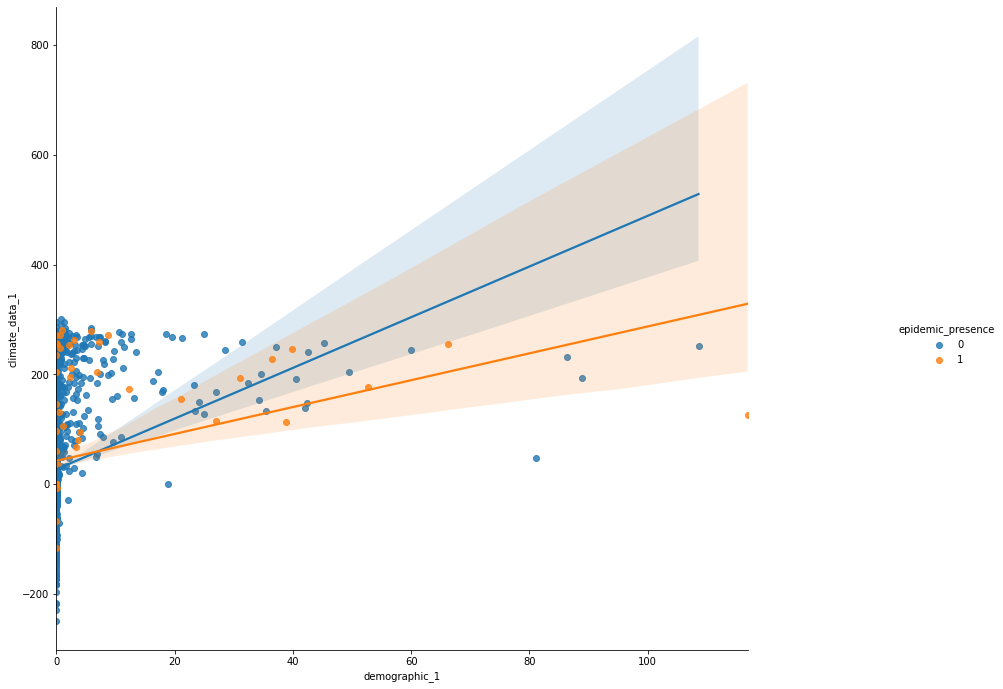

In [54]:
sns.lmplot('demographic_1','climate_data_1', epidemics_1, hue='epidemic_presence')
#this will  Get a reference to the current figure.
fig = plt.gcf()
#this will alter the size of the graph
fig.set_size_inches(15, 10)
plt.show()

In [55]:
accuracy, Y_test, X_test, theta, m = run_gradient_descent_accuracy(epidemics_1, ['epidemic_presence'], ["climate_data_1", "demographic_1"])
print(accuracy)

0.9441591784338896


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

####Random Forest Classifier

In [56]:
predictors = epidemics_1.drop(['Unnamed: 0', 'disease', 'animal_code', 'animal', 'epidemic_presence', 'origin_lat', 'origin_long', 'new_lat', 'new_long', 'polygon'], axis=1)
predict = epidemics_1['epidemic_presence']
feature_list = list(predictors.columns)
features = np.array(predictors)

train_features, test_features, train_labels, test_labels = train_test_split(features, predict, test_size = 0.25, random_state = 42)


rf1 = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf1.fit(train_features,train_labels)
print("%.4f" % rf1.oob_score_)

0.9352


In [57]:
importances = pd.DataFrame(rf1.feature_importances_, index=feature_list, columns=['importance'])
importances

,importance
forest_loss_1,0.093354
climate_data_1,0.182794
demographic_1,0.203345
cropcover_1,0.083674
water_1,0.436834


In [59]:
predictors = epidemics_1.drop(['Unnamed: 0', 'disease', 'animal_code', 'animal', 'epidemic_presence', 'origin_lat', 'origin_long', 'new_lat', 'new_long', 'polygon'], axis=1)
predict = epidemics_1['epidemic_presence']
feature_list = list(predictors.columns)
features = np.array(predictors)

train_features, test_features, train_labels, test_labels = train_test_split(features, predict, test_size = 0.25, random_state = 42)


rf1 = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf1.fit(train_features,train_labels)
print("%.4f" % rf1.oob_score_)

0.9352


In [60]:
# Pull out one tree from the forest
tree = rf1.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 5)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [61]:
predictors = epidemics_3.drop(['Unnamed: 0', 'disease', 'animal_code', 'animal', 'epidemic_presence', 'origin_lat', 'origin_long', 'new_lat', 'new_long', 'polygon'], axis=1)
predict = epidemics_3['epidemic_presence']
feature_list = list(predictors.columns)
features = np.array(predictors)

train_features, test_features, train_labels, test_labels = train_test_split(features, predict, test_size = 0.25, random_state = 42)


rf2 = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf2.fit(train_features,train_labels)
print("%.4f" % rf2.oob_score_)

0.9385


In [62]:
importances = pd.DataFrame(rf2.feature_importances_, index=feature_list, columns=['importance'])
importances

,importance
forest_loss_3,0.137688
climate_data_3,0.155674
demographic_3,0.134491
cropcover_3,0.115970
water_3,0.456178


###Predictions

In [67]:
non_epidemic_sites = pd.read_csv('non_epidemic_sites.csv')
cities = pd.read_csv('cities.csv')
#Clean Data
non_epidemic_sites = non_epidemic_sites.fillna(0)

In [70]:
city_predictions = non_epidemic_sites.merge(locations2, left_on=['forest_loss_3', 'climate_data_3', 'demographic_3', 'cropcover_3', 'water_3'], right_on=['forest_loss_3', 'climate_data_3', 'demographic_3', 'cropcover_3', 'water_3'])

In [71]:
city_predictions

,Unnamed: 0,latitude,longitude,polygon,forest_loss_3,climate_data_3,demographic_3,cropcover_3,water_3,predictions
0,0,35.6897,139.6922,"[(139.80267817585457, 35.68964930715977), (139...",172.270588,153.604123,366.017431,2.409802,11.059193,0
1,1,-6.2146,106.8451,"[(106.93545900656932, -6.214592281157551), (10...",82.000000,273.615160,1067.663441,2.071155,2.273116,0
2,2,28.6600,77.2300,"[(77.33229542663332, 28.659961369115155), (77....",179.000000,251.113058,1231.944362,3.241345,5.443513,0
3,3,18.9667,72.8333,"[(72.92825508712735, 18.966675669067463), (72....",1.000000,268.105694,1335.820489,0.416200,263.741005,0
4,4,14.5958,120.9772,"[(121.07000754503886, 14.59578155420861), (121...",120.000000,272.216588,1965.080691,0.882313,153.299600,0
...,...,...,...,...,...,...,...,...,...,...
19177,14995,39.4667,-8.4667,"[(-8.350494567255849, 39.46664194234629), (-8....",37368.972549,164.540601,6.197272,2.780928,1.933480,0
19178,14996,42.8833,74.8500,"[(74.97240625232841, 42.88323456546932), (74.9...",36.000000,102.192166,4.914395,2.361812,0.713116,0
19179,14997,43.3419,142.3833,"[(142.50662363431616, 43.341833514361284), (14...",5291.227451,55.400639,0.943535,0.634589,0.701119,0
19180,14998,44.0771,-75.7975,"[(-75.67265966677827, 44.077031795956295), (-7...",2985.403922,68.568725,6.156689,4.037219,4.551953,0


In [72]:
city_predictions = city_predictions.merge(cities, left_on=['latitude', 'longitude'], right_on=['lat', 'lng'])

In [73]:
city_predictions[city_predictions['predictions'] == 1]

,Unnamed: 0,latitude,longitude,polygon,forest_loss_3,climate_data_3,demographic_3,cropcover_3,water_3,predictions,city_ascii,lat,lng
16049,12551,29.0224,-81.2873,"[(-81.1846494790706, 29.02236078930914), (-81....",38608.733333,212.424628,10.918186,4.440044,11.762629,1,DeLand,29.0224,-81.2873


###Using Random Forest Regressor

In [74]:
predictors = epidemics_3.drop(['Unnamed: 0', 'disease', 'animal_code', 'animal', 'epidemic_presence', 'origin_lat', 'origin_long', 'new_lat', 'new_long', 'polygon'], axis=1)
predict = epidemics_3['epidemic_presence']
feature_list = list(predictors.columns)
features = np.array(predictors)

train_features, test_features, train_labels, test_labels = train_test_split(features, predict, test_size = 0.25, random_state = 42)

rf3 = RandomForestRegressor(bootstrap = True)
rf3.fit(train_features,train_labels)
test_predict = rf3.predict(test_features)
mse = mean_squared_error(test_predict, test_labels)
np.sqrt(mse)

0.25392047174718574

In [75]:
locations3 = non_epidemic_sites.drop(['Unnamed: 0', 'latitude', 'longitude', 'polygon'], axis=1)
locations3['predictions'] = rf3.predict(locations3)

In [76]:
city_predictions = non_epidemic_sites.merge(locations3, left_on=['forest_loss_3', 'climate_data_3', 'demographic_3', 'cropcover_3', 'water_3'], right_on=['forest_loss_3', 'climate_data_3', 'demographic_3', 'cropcover_3', 'water_3'])

In [77]:
city_predictions = city_predictions.merge(cities, left_on=['latitude', 'longitude'], right_on=['lat', 'lng'])

In [78]:
a = city_predictions.sort_values('predictions', ascending=False)

In [79]:
org = non_epidemic_sites.reset_index()
new = locations.reset_index()
city_predictions = org.merge(new, left_on='index', right_on='index')

In [92]:
#Population Data and Epidemic Data
a["predictions"] = pd.to_numeric(a["predictions"], downcast="float")
a = a[a['predictions']>.4]
a = a.reset_index()
locations = a[['lat', 'lng']]
locationlist = locations.values.tolist()
a['color'] = np.where(a['predictions']>.65, 'red', 'orange')
a

,index,Unnamed: 0,latitude,longitude,polygon,forest_loss_3,climate_data_3,demographic_3,cropcover_3,water_3,predictions,city_ascii,lat,lng,color
0,8336,4565,6.9100,0.6281,"[(0.7185844213351589, 6.909991409746587), (0.7...",7712.556863,253.644654,26.930255,3.924145,0.000910,0.79,Kpalime,6.9100,0.6281,red
1,8609,4842,16.4333,-95.0194,"[(-94.9257676369212, 16.433279111781317), (-94...",5015.690196,273.331360,23.268603,3.930902,7.079015,0.77,Juchitan de Zaragoza,16.4333,-95.0194,red
2,9900,6154,13.6333,-86.4833,"[(-86.39088120683978, 13.63328281760996), (-86...",6149.258824,225.551179,15.275414,3.923208,0.121352,0.74,Ocotal,13.6333,-86.4833,red
3,9312,5542,14.2900,-89.9000,"[(-89.80731914283174, 14.289981956731273), (-8...",4995.254902,225.928525,25.725917,3.944192,0.178440,0.73,Jutiapa,14.2900,-89.9000,red
4,6712,2912,9.9833,122.8167,"[(122.90790346215688, 9.983287525442405), (122...",1599.168627,270.220960,35.708927,3.923305,11.518421,0.73,Kabankalan,9.9833,122.8167,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,17715,14273,-22.0941,-70.2010,"[(-70.1040950464571, -22.094071275097367), (-7...",0.000000,176.473355,0.315997,0.000000,501.841717,0.41,Tocopilla,-22.0941,-70.2010,orange
496,6631,2830,15.9281,120.3489,"[(120.44229458835787, 15.928079787532944), (12...",1408.905882,274.851587,105.401990,3.141657,9.272678,0.41,San Carlos City,15.9281,120.3489,orange
497,7784,4010,33.2847,131.4911,"[(131.59845147801852, 33.28465364460736), (131...",3675.698039,138.761943,18.391585,1.585428,102.897198,0.41,Beppu,33.2847,131.4911,orange
498,17677,14235,34.1081,-84.0560,"[(-83.94761962828032, 34.10805218710083), (-83...",43715.843137,151.234295,24.192956,2.972306,37.121136,0.41,Sugar Hill,34.1081,-84.0560,orange


In [93]:
pop_map = folium.Map(location=[45, 68], tiles='Stamen Terrain', zoom_start=3)

for point in range(1, len(locationlist)):
    folium.Marker(locationlist[point], icon=folium.Icon(color=a["color"][point])).add_to(pop_map)

In [94]:
pop_map